In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow import keras
from keras.layers import ConvLSTM2D,BatchNormalization,Conv2D,Reshape,Conv3D,MaxPooling2D,MaxPooling3D,Flatten,Dense,RepeatVector,TimeDistributed
from keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import os

In [2]:
#open the image stack
with rasterio.open("C:/Users/Richard Omondi/Downloads/phlipines cropped/Bukidnon_temp_cropped.tif") as src:
    #Read the image data
    image = src.read()

In [3]:
#Covert image to float32 to save memory
image=image.astype('float32')

In [4]:
#Check for nan values
Xa=np.count_nonzero(np.isnan(image))
print(Xa)

203825


In [5]:
#Check the meta data of the image
zx=src.meta
print(zx)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9, 'height': 12, 'count': 6575, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.09999999999999432, 0.0, 124.54999999998266,
       0.0, -0.09999999999999432, 8.650000000004624)}


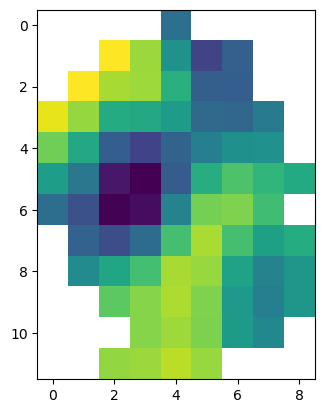

In [7]:
#Visualize a single band in the image
plt.imshow(image[6000])

In [ ]:
#Check the shape of the image
image.shape

In [9]:
#Masking of NaN values
# Fill NaN values with zero
image[np.isnan(image)] = 0

# Check the modified image
print(image)

[[[ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.       24.770014 ... 18.965845  0.        0.      ]
  [ 0.       24.242395 23.91421  ... 18.85357   0.        0.      ]
  ...
  [ 0.        0.       23.829187 ... 21.678217 20.127405 20.96972 ]
  [ 0.        0.        0.       ... 21.641657 20.411005  0.      ]
  [ 0.        0.       24.748102 ...  0.        0.        0.      ]]

 [[ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.       24.423517 ... 18.935083  0.        0.      ]
  [ 0.       23.797266 23.559809 ... 18.822107  0.        0.      ]
  ...
  [ 0.        0.       23.950464 ... 21.670832 20.2362   21.071527]
  [ 0.        0.        0.       ... 21.63482  20.520563  0.      ]
  [ 0.        0.       24.873163 ...  0.        0.        0.      ]]

 [[ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.       24.51211  ... 18.851221  0.        0.      ]
  [ 0.       23.686274 23.653193

In [12]:
#Create an input sequence function with a sequence length of 5
sequence_length = 5

# create a sequence for the images
def stack_images_to_seq(image, sequence_length):
    num_images = image.shape[0]
    sequences=[]
    
    for i in range(num_images-sequence_length + 1):
        sequence = image[i:i+sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

In [13]:
#Apply the input sequence function to the image
sequences = stack_images_to_seq(image,sequence_length)

In [14]:
#Check shape of the sequence
sequences.shape

(6571, 5, 12, 9)

In [15]:
#Normalize the data,we use 255 since it is an image
sequences = sequences/255

In [17]:
from sklearn.model_selection import train_test_split
#0.0555133079847908745
# Split sequences into X and y
X = sequences[:, :-1]  # Input sequences
y = sequences[:,1]   # Output sequence

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the split sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5256, 4, 12, 9)
y_train shape: (5256, 12, 9)
X_test shape: (1315, 4, 12, 9)
y_test shape: (1315, 12, 9)


In [18]:
# Preprocess the training and test data
X_train_processed = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_test_processed = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3]))

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, TimeDistributed, Flatten, Dense, Dropout

# Define 2D CNN-LSTM model
model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu'), input_shape=(1, 4, 12, 9)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")))                          
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dense(12*9, activation='relu'))
model.add(Reshape((12, 9)))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 2, 10, 64)     5248      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 1, 5, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 320)           0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               168400    
                                                                 
 dense (Dense)               (None, 108)               10908     
                                                        

In [22]:
# Fit the model with the preprocessed data
model.fit(X_train_processed, y_train, batch_size=4, validation_data=(X_test_processed, y_test), epochs=100)

Epoch 1/100
1314/1314 [==============================] - 23s 11ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 2/100
1314/1314 [==============================] - 14s 11ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/100
1314/1314 [==============================] - 15s 11ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/100
1314/1314 [==============================] - 12s 9ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/100
1314/1314 [==============================] - 10s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
1314/1314 [==============================] - 13s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/100
1314/1314 [==============================] - 12s 9ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/100
1314/1314 [==============================] - 13s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/100
1314/1314 [==============================] - 11s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/100
1314/1314 [==============================] - 8

In [23]:
#RMSE test
 import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you have already trained the model and obtained predictions
X_pred = model.predict(X_test_processed)
X_pred1= model.predict(X_train_processed)
# Reshape the predictions and ground truth to match the original shape
X_pred = X_pred.reshape((X_pred.shape[0],X_pred.shape[1]*X_pred.shape[2]))
X_pred1 = X_pred1.reshape((X_pred1.shape[0],X_pred1.shape[1]*X_pred1.shape[2]))
y_test_original = y_test.reshape((y_test.shape[0], y_test.shape[1]*y_test.shape[2]))
y_train_original = y_train.reshape((y_train.shape[0], y_train.shape[1]*y_train.shape[2]))

# Calculate RMSE
mse1= mean_squared_error(y_train_original,X_pred1)
mse = mean_squared_error(y_test_original, X_pred)
rmse = np.sqrt(mse)
rmse1= np.sqrt(mse1)
print("Test Root Mean Squared Error (RMSE):", rmse*255)
print("Train Root Mean Squared Error (RMSE):",rmse1*255)

165/165 [==============================] - 1s 5ms/step
Test Root Mean Squared Error (RMSE): 0.184999544871971
Train Root Mean Squared Error (RMSE): 0.18454052653396502


In [24]:
#RMSLE test
from sklearn.metrics import mean_squared_log_error
# Take the logarithm of the predicted and ground truth values
X_pred = X_pred*255
X_pred1 = X_pred1*255
y_test_original = y_test_original*255
y_train_original = y_train_original*255
X_pred_log = np.log1p(X_pred)
X_pred1_log = np.log1p(X_pred1)
y_test_original_log = np.log1p(y_test_original)
y_train_original_log = np.log1p(y_train_original)
# Calculate RMSLE
msle = mean_squared_log_error(y_test_original_log, X_pred_log)
msle1 = mean_squared_log_error(y_train_original_log, X_pred1_log)
rmsle = np.sqrt(msle)
rmsle1 = np.sqrt(msle1)

print("Test Root Mean Squared Logarithmic Error (RMSLE):", rmsle)
print("Train Root Mean Squared Logarithmic Error (RMSLE):", rmsle1)

Test Root Mean Squared Logarithmic Error (RMSLE): 0.001930654
Train Root Mean Squared Logarithmic Error (RMSLE): 0.0019208333


In [27]:
# Reshape y_pred and y_test_original to match the original image dimensions
height = 12
width = 9
X_pred_reshaped = X_pred.reshape(-1, height, width)
y_test_original_reshaped = y_test_original.reshape(-1, height, width)

In [28]:
#REcheck the shape 
X_pred_reshaped.shape

(1315, 12, 9)

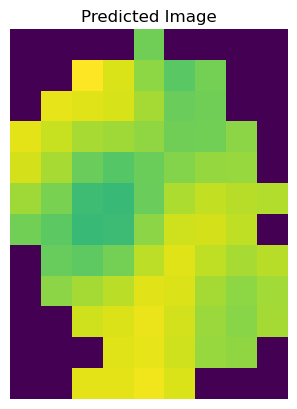

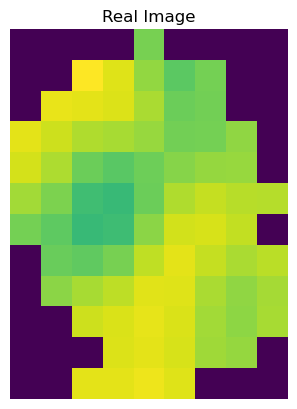

In [29]:
# Visualize the images
plt.figure()
plt.title('Predicted Image')
plt.imshow(X_pred_reshaped[1])
plt.axis('off')
plt.show()


plt.figure()
plt.title('Real Image')
plt.imshow(y_test[1])
plt.axis('off')
plt.show()

In [39]:
#Predict future images fore the years 2022-2023
import numpy as np

num_predictions = 730  # Number of future predictions desired
prediction_seq = np.copy(X_test)

for _ in range(num_predictions):
    next_image = model.predict(prediction_seq[:, -4:, :, :]) 
    next_image = np.expand_dims(next_image, axis=1)
    next_image = np.tile(next_image, (1, 4, 1, 1))
    prediction_seq = np.concatenate((prediction_seq, next_image), axis=1)

future_images = prediction_seq[-num_predictions:, -4:, :, :]

print("Predicted future images shape:", future_images.shape)


42/42 [==============================] - 1s 11ms/step
Predicted future images shape: (730, 4, 12, 9)


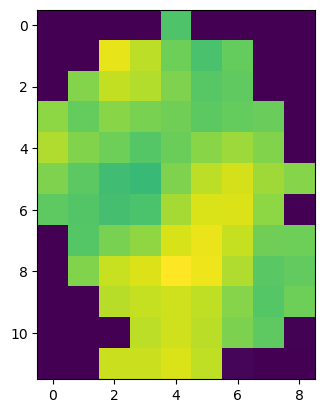

In [40]:
#Visualize the future image
plt.imshow(future_images[700,0,:,:])

In [ ]:
#THE END OF THE NOTEBOOK

In [64]:
import numpy as np

# Define the number of future predictions
num_predictions = 730


# Create a copy of the input sequence for making predictions
prediction_seq = np.copy(X_test)

# Generate future predictions
for i in range(num_predictions):
    # Predict the next image in the sequence
    next_image = model.predict(prediction_seq[:, -4:, :, :])  # Assuming sequence_length = 4
    next_image = np.expand_dims(next_image, axis=1)

    # Tile next_image to match the sequence length of prediction_seq
    next_image = np.tile(next_image, (1, 4, 1, 1))  # Assuming sequence_length = 4

    # Append the predicted image to the prediction sequence
    prediction_seq = np.concatenate((prediction_seq, next_image), axis=1)

# Extract the predicted future images
future_images = prediction_seq[-num_predictions:, -4:, :, :] 

# Reshape the predicted images to match the original shape
future_images = np.reshape(future_images, (num_predictions, 4, 29, 16))  # Assuming sequence_length = 4

# Print the shape of the predicted future images
print("Predicted future images shape:", future_images.shape)


42/42 [==============================] - 1s 30ms/step
Predicted future images shape: (730, 4, 29, 16)


In [65]:
future_images.shape

(730, 4, 29, 16)

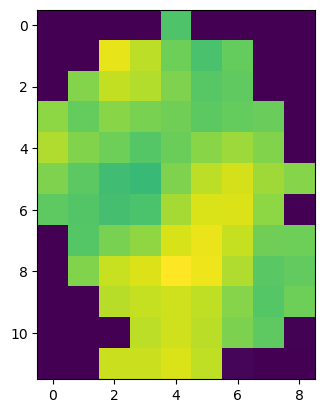

In [42]:
plt.imshow(future_images[728,0,:,:])

In [43]:
future_images*255

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , 21.668064  , ..., 17.219755  ,
           0.        ,  0.        ],
         [ 0.        , 18.304773  , 20.492426  , ..., 17.015894  ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        , 20.125639  , ..., 18.409218  ,
          16.545156  , 17.58758   ],
         [ 0.        ,  0.        ,  0.        , ..., 18.101498  ,
          16.895174  ,  0.11643763],
         [ 0.        ,  0.        , 20.69644   , ...,  0.42009702,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , 21.668064  , ..., 17.219755  ,
           0.        ,  0.        ],
         [ 0.        , 18.304773  , 20.492426  , ..., 17.015894  ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [44]:
ff_images=future_images*255

In [45]:
ff_images

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , 21.668064  , ..., 17.219755  ,
           0.        ,  0.        ],
         [ 0.        , 18.304773  , 20.492426  , ..., 17.015894  ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        , 20.125639  , ..., 18.409218  ,
          16.545156  , 17.58758   ],
         [ 0.        ,  0.        ,  0.        , ..., 18.101498  ,
          16.895174  ,  0.11643763],
         [ 0.        ,  0.        , 20.69644   , ...,  0.42009702,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , 21.668064  , ..., 17.219755  ,
           0.        ,  0.        ],
         [ 0.        , 18.304773  , 20.492426  , ..., 17.015894  ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [46]:
def unstack_seq_to_images(sequences):
    num_sequences = sequences.shape[0]
    sequence_length = sequences.shape[1]
    image_height = sequences.shape[2]
    image_width = sequences.shape[3]
    
    images = np.reshape(sequences, (num_sequences * sequence_length, image_height, image_width))
    images = images[:num_sequences + sequence_length-1]  # Select only the original number of images
    
    return images

In [47]:
reconstructed_images = unstack_seq_to_images(ff_images)
print(reconstructed_images.shape)

(733, 12, 9)


In [48]:
#Export the images
from osgeo import gdal
import numpy as np

# Define output file name and format
out_file = "Bukidnon_temp_predicted_images.tif"
driver = gdal.GetDriverByName("GTiff")

# Define image dimensions and number of bands
num_bands = reconstructed_images.shape[0]
height = reconstructed_images.shape[1]
width = reconstructed_images.shape[2]

# Set default projection and geotransform
projection = ""
geotransform = (0, 1, 0, 0, 0, 1)  # Default geotransform values

# Create output file with specified dimensions and number of bands
out_data_set = driver.Create(out_file, width, height, num_bands, gdal.GDT_Float32)

# Set projection and geotransform information for output file
out_data_set.SetProjection(projection)
out_data_set.SetGeoTransform(geotransform)

# Write each band to the output file
for i in range(num_bands):
    out_band = out_data_set.GetRasterBand(i + 1)
    band_data = reconstructed_images[i, :, :]
    out_band.WriteArray(band_data)
    out_band.FlushCache()

# Close the output file
out_data_set = None



TypeError: from_bounds() missing 5 required positional arguments: 'south', 'east', 'north', 'width', and 'height'

In [ ]:
f01=future_images[:359]

In [ ]:
f01.shape

(359, 4, 13, 15)

In [ ]:
X1 = sequences[:,:-1]

In [ ]:
X1.shape

(6209, 4, 13, 15)

In [ ]:
last_image = X1[-359:]

In [ ]:
last_image.shape

(359, 4, 13, 15)

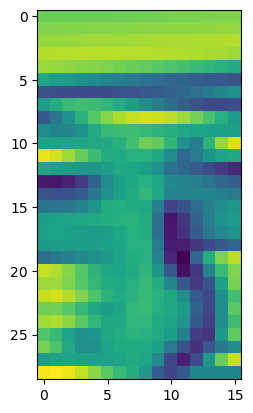

In [49]:
plt.imshow(image[1])

In [ ]:
f1=f01
f2=last_image
f3=f31

In [ ]:
f11 = f1.reshape(f1.shape[0],f1.shape[1]*f1.shape[2]*f1.shape[3])
f22 = f2.reshape(f2.shape[0],f2.shape[1]*f2.shape[2]*f2.shape[3])
f33 = f3.reshape(f3.shape[0],f3.shape[1]*f3.shape[2]*f3.shape[3])

In [ ]:
# Projection for year 2021
with rasterio.open('C:/Users/Richard Omondi/Downloads/modified_tmean.tif') as src:
     # Read the image data
    image2 = src.read()

In [ ]:
image2.shape

(363, 13, 15)

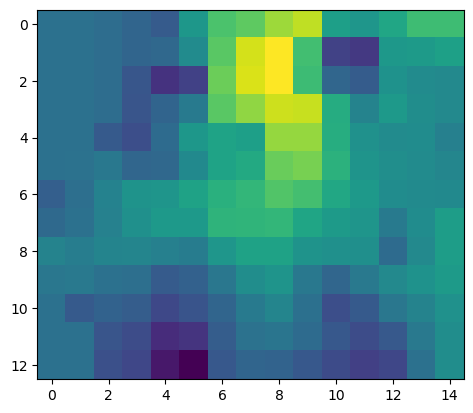

In [ ]:
plt.imshow(image2[310])

In [ ]:
#open the image stack
with rasterio.open("C:/Users/Richard Omondi/Downloads/tmean_2021.tif") as src:
    #Read the image data
    image = src.read()
# Get the shape of the image
num_bands, height, width = image.shape

# Reshape the image to a 2D array for each band
imputed_image = np.zeros((num_bands, height, width))

for band in range(num_bands):
    # Get the 2D array for the current band
    image_2d = image[band, :, :]

    # Create an instance of SimpleImputer with desired strategy
    imputer = SimpleImputer(strategy='mean')

    # Perform imputation on the band
    imputed_band = imputer.fit_transform(image_2d)

    # Store the imputed band in the imputed_image array
    imputed_image[band, :, :] = imputed_band   

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

# Get the shape of the image
num_bands, height, width = image.shape

# Reshape the image to a 2D array for each band
imputed_image = np.zeros((num_bands, height, width))

for band in range(num_bands):
    # Get the 2D array for the current band
    image_2d = image[band, :, :]

    # Create an instance of SimpleImputer with desired strategy
    imputer = SimpleImputer(strategy='mean')

    # Perform imputation on the band
    imputed_band = imputer.fit_transform(image_2d)

    # Store the imputed band in the imputed_image array
    imputed_image[band, :, :] = imputed_band

# Reshape the imputed image to match the desired shape
imputed_image = imputed_image[:, :new_shape[1], :new_shape[2]]

# Open the original image stack
with rasterio.open("C:/Users/Richard Omondi/Downloads/tmean_2021.tif") as src:
    # Read the image data
    image = src.read()

    # Define the new shape and resolution
    new_shape = (363, 13, 15)
    new_resolution = 0.09999999999999432

    # Calculate the new transform based on the new resolution
    transform = Affine(src.transform.a / (src.width / new_shape[2]),
                       src.transform.b,
                       src.transform.c,
                       src.transform.d,
                       src.transform.e / (src.height / new_shape[1]),
                       src.transform.f)

    # Create a new file for the modified image stack
    with rasterio.Env():
        profile = src.profile
        profile.update(width=new_shape[2], height=new_shape[1], transform=transform)

        with rasterio.open("C:/Users/Richard Omondi/Downloads/modified_tmean.tif", 'w', **profile) as dst:
            # Write the modified image data
            dst.write(imputed_image)

In [ ]:
imputed_image.shape

(363, 13, 15)

In [ ]:
sequences1 = stack_images_to_seq(imputed_image,sequence_length)

In [ ]:
sequences1.shape

(359, 5, 13, 15)

In [ ]:
f31=sequences1[:,:-1]

In [ ]:
f31.shape

(359, 4, 13, 15)

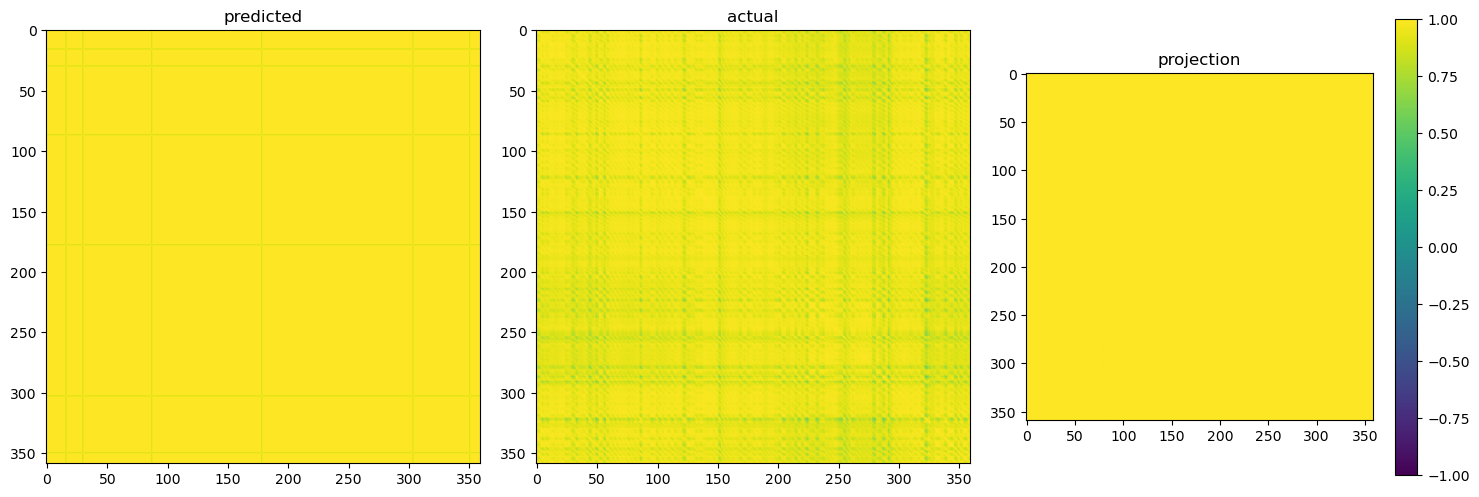

In [ ]:
#correlate
corr_matrix1 = np.corrcoef(f11)
corr_matrix2 = np.corrcoef(f22)
corr_matrix3 = np.corrcoef(f33)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(corr_matrix1, vmin=-1, vmax=1)
plt.title('predicted')

plt.subplot(132)
plt.imshow(corr_matrix2, vmin=-1, vmax=1)
plt.title('actual')

plt.subplot(133)
plt.imshow(corr_matrix3,  vmin=-1, vmax=1)
plt.title('projection')

plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
f2[1]*255

array([[[22.48546791, 21.91321373, 21.72774696, 23.45296669,
         23.89272499, 23.44237709, 23.46813393, 23.73797035,
         24.00408363, 24.02315712, 24.76284218, 25.66578674,
         26.02728844, 26.45691872, 26.75891685],
        [22.48546791, 21.12816811, 21.84414101, 23.26366615,
         23.77184486, 22.95708656, 22.49190712, 23.17540932,
         23.91689491, 23.96932411, 24.66692543, 25.1944828 ,
         25.85607338, 26.45691872, 26.75891685],
        [21.91210365, 21.56966591, 21.90926552, 23.26656532,
         24.07903481, 23.30990028, 22.75179482, 23.3786869 ,
         24.15935707, 24.1536808 , 24.64666176, 25.19188881,
         25.95601845, 26.45691872, 26.75891685],
        [22.44555092, 22.48043251, 22.39675331, 23.57219887,
         24.37093544, 23.7199955 , 23.60143471, 23.84249306,
         24.42131996, 24.63442421, 24.98018837, 25.40947914,
         26.08150673, 26.45691872, 26.75891685],
        [22.77968788, 22.33400917, 22.30358315, 22.93969154,
         23

In [ ]:
f1[1]*255

array([[[19.22267642, 18.41882575, 17.409712  , 17.72084311,
         17.3911253 , 18.25696964, 18.65994561, 18.04199997,
         18.39664064, 18.00375313, 18.88026539, 21.12279866,
         21.5021209 , 22.24425148, 23.12323362],
        [19.2211052 , 17.95884904, 17.4470013 , 18.1253181 ,
         17.88700439, 18.23207907, 18.54183655, 18.55992548,
         19.08375777, 18.44743632, 19.39850058, 19.95955188,
         20.97148318, 22.33243715, 22.94899967],
        [18.96415349, 17.82826714, 17.80308019, 18.43005605,
         18.08769252, 18.57024383, 19.05362919, 19.17002454,
         19.57624935, 18.87660049, 19.69000384, 20.38786869,
         21.44044071, 22.1917345 , 22.98255946],
        [18.88265546, 18.62528387, 18.36894393, 18.5950622 ,
         18.76816761, 19.36702877, 20.03618237, 19.3832691 ,
         19.53016162, 19.5231263 , 20.20023856, 20.82551971,
         21.49332058, 22.29646828, 23.22835688],
        [19.99717556, 19.01007213, 18.44150104, 18.79386373,
         19

In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Reshape the datasets
f11 = f1.reshape(f1.shape[0], f1.shape[1] * f1.shape[2] * f1.shape[3])
f22 = f2.reshape(f2.shape[0], f2.shape[1] * f2.shape[2] * f2.shape[3])
f33 = f3.reshape(f3.shape[0],f3.shape[1]*f3.shape[2]*f3.shape[3])
f11=f11*255
f22=f22*255
# Calculate correlation scores
corr_12, _ = pearsonr(f11.flatten(), f22.flatten())
corr_13, _ = pearsonr(f11.flatten(), f33.flatten())
corr_23, _ = pearsonr(f22.flatten(), f33.flatten())

# Print the correlation scores
print("Correlation between predicted and actual:", corr_12)
print("Correlation between predicted and projection:", corr_13)
print("Correlation between actual and projection:", corr_23)


Correlation between predicted and actual: 0.646466575163128
Correlation between predicted and projection: -0.719432838376246
Correlation between actual and projection: -0.4226965330496448


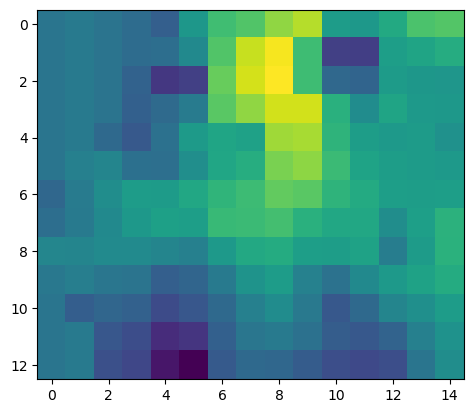

In [ ]:
plt.imshow(f31[10,0,:,:])

In [ ]:
f31.shape

(359, 4, 13, 15)

In [ ]:
import rasterio
from rasterio.transform import Affine

# Open the original image stack
with rasterio.open("C:/Users/Richard Omondi/Downloads/tmean_2021.tif") as src:
    # Read the image data
    image = src.read()

    # Define the new shape and resolution
    new_shape = (363, 13, 15)
    new_resolution = 0.09999999999999432

    # Calculate the new transform based on the new resolution
    transform = Affine(src.transform.a / (src.width / new_shape[2]),
                       src.transform.b,
                       src.transform.c,
                       src.transform.d,
                       src.transform.e / (src.height / new_shape[1]),
                       src.transform.f)

    # Create a new file for the modified image stack
    with rasterio.Env():
        profile = src.profile
        profile.update(width=new_shape[2], height=new_shape[1], transform=transform)

        with rasterio.open("C:/Users/Richard Omondi/Downloads/modified_tmean.tif", 'w', **profile) as dst:
            # Write the modified image data
            dst.write(image)